# PWR Pin 2D Axial Symmetry - Post Process

In [1]:
import numpy as np
import pandas as pd
import pickle

from scipy.interpolate import LinearNDInterpolator

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
n_div_to_plot = [4, 16, 64, 256]

L_active = 366
# The division in slices acts only on the active region
slices = [np.linspace(-L_active/2, L_active/2, n_div+1) for n_div in n_div_to_plot]

comp_time = list()
axial_qties = list()
averages = list()
data_2d = list()

for ii, n_div in enumerate(n_div_to_plot):
    with open('results_'+str(n_div)+'div_60kW/results.pin', 'rb') as f:
        data = pickle.load(f)
        # 0: computational time in min
        # 1: axial q3 and bulk fluid temperature
        # 2: temperature average: [0] is the solid, [1] the fluid
        # 3: 2D temperature
        
    comp_time.append(dict())
    comp_time[ii]['Time'] = data[0]['Wall time']
    comp_time[ii]['CPU Time'] = data[0]['CPU time']
        
    axial_qties.append(dict())
    axial_qties[ii]['n_div']    = n_div
    axial_qties[ii]['z'] = data[1]['z']
    axial_qties[ii]['axial_q3'] = data[1]['q3']
    axial_qties[ii]['axial_Tb'] = data[1]['T_bulk']
        
    averages.append(dict())
    averages[ii]['Fuel'] = data[2][0]
    averages[ii]['Water'] = data[2][1]    
    
    data_2d.append(data[3])
    
single_physics = dict()
with open('results_2div_Tconstant/results.pin', 'rb') as f:
        data = pickle.load(f)

single_physics['z'] = data[1]['z']
single_physics['axial_q3'] = data[1]['q3']
single_physics['axial_Tb'] = data[1]['T_bulk']
single_physics['2d_data'] = data[3]


def compute_axial(z, data_2d, centreline = False):
    T_interpolant = LinearNDInterpolator(np.vstack([data_2d['X'].flatten(), 
                                                    data_2d['Y'].flatten()]).T, 
                                         data_2d['T'].T.flatten())
    T_ax = np.zeros_like(z)
    fuel_or = 0.819/2
    for jj in range(len(z)):
        if centreline:
            T_ax[jj] = T_interpolant(z[jj], 0)    
        else:
            T_ax[jj] = np.mean(T_interpolant(z[jj],np.linspace(-fuel_or, fuel_or)))
    return T_ax


lw = 4
mark_size = 15
Ef = 200e6 * 1.6e-19

In [3]:
castagna_res = dict()

df = pd.read_csv('./castagna_res/castagna_fuel_temperature.csv')
castagna_res['fuel_temp'] = df.to_numpy()

df = pd.read_csv('./castagna_res/castagna_coolant_temperature.csv')
castagna_res['coolant_temp'] = df.to_numpy()

df = pd.read_csv('./castagna_res/castagna_fission_rate_density.csv')
castagna_res['fission_rate'] = df.to_numpy()

def normalize_temperature(data):
    minimum = min(data)
    maximum = max(data)
    
    return (data - minimum) / (maximum - minimum)

def normalize_ave_temperature(data, data_continuous):
    minimum = min(data_continuous)
    maximum = max(data_continuous)
    
    return (data - minimum) / (maximum - minimum)

def normalize_power(data):
    maximum = max(data)
    
    return data / maximum

## Computational Time

In [4]:
time_pure = dict()
cpu_time = dict()

for ii, n_div in enumerate(n_div_to_plot):
    time_pure[n_div] = comp_time[ii]['Time']
    cpu_time[n_div]  = comp_time[ii]['CPU Time']

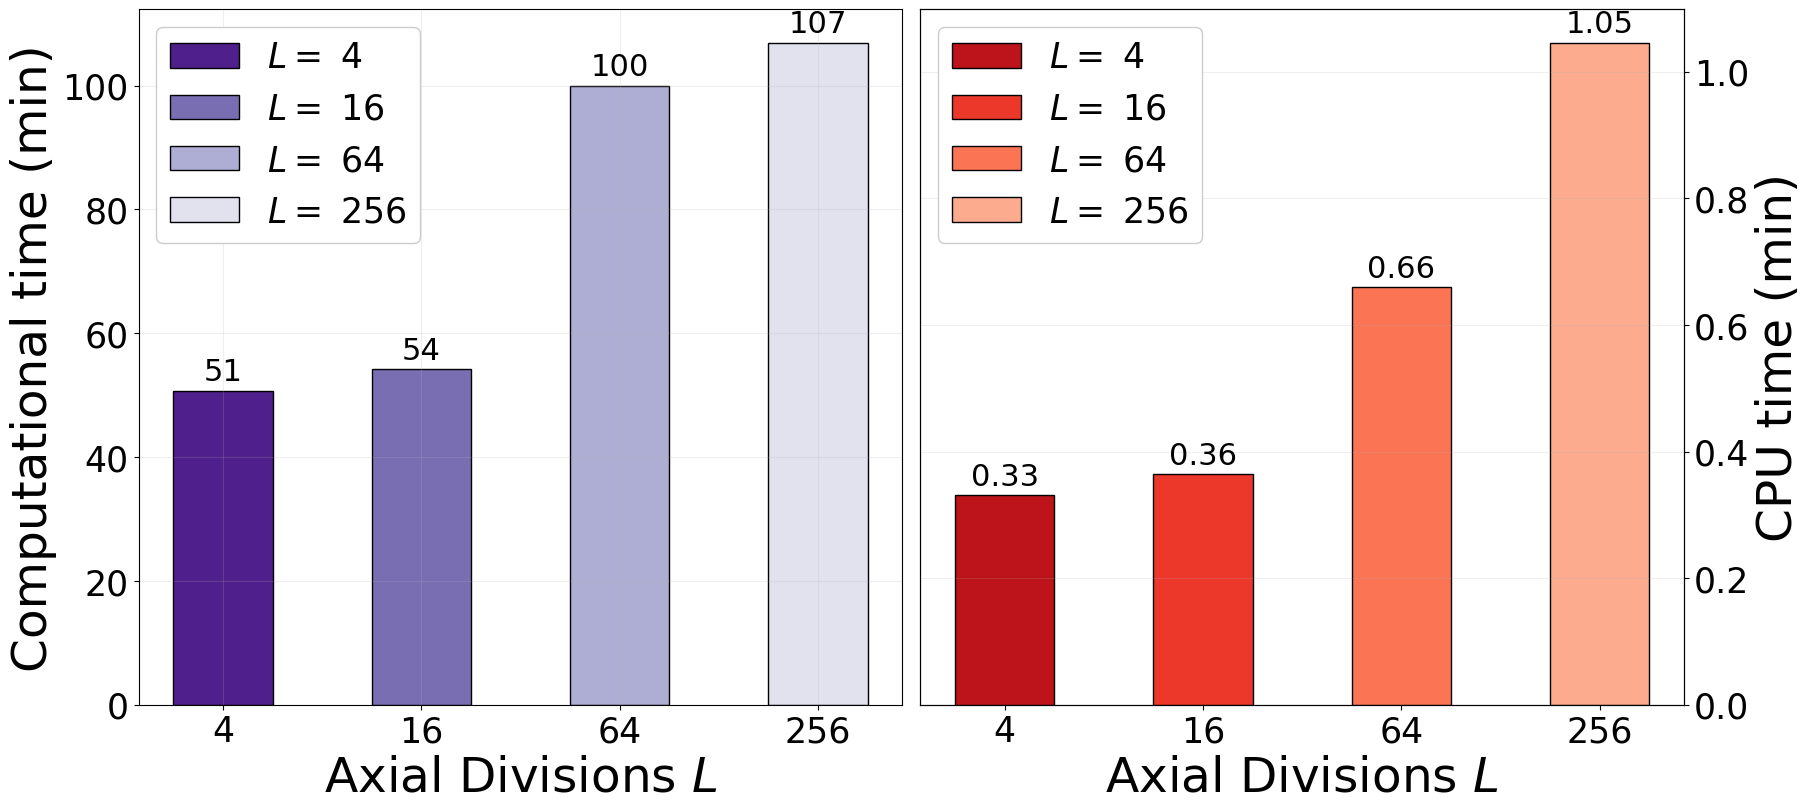

In [6]:
width = 0.5  # the width of the bars
multiplier = 0

fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(18,8))

colors = cm.Purples_r(np.linspace(0.1, 0.8, len(n_div_to_plot)))

ax = axs[0]
for attribute, measurement in time_pure.items():
    rects = ax.bar(multiplier, measurement, width, label='$L=$ '+str(attribute), color=colors[multiplier], edgecolor='black')
    ax.bar_label(rects, padding=3, fmt='%.0f', fontsize=22)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel(r"Axial Divisions $L$", fontsize = 35)
ax.set_ylabel(r"Computational time (min)", fontsize = 35)
ax.tick_params(axis='y', labelsize=25)
ax.set_xticks(np.arange(0, len(n_div_to_plot)), n_div_to_plot, fontsize = 25)
ax.legend(loc='upper left', fontsize = 25, framealpha=1)
ax.grid(which='major',linestyle='-', alpha=0.2)
ax.grid(which='minor',linestyle='--', alpha=0.2)

ax = axs[1].twinx()
axs[1].set_yticks([], [])
colors = cm.Reds_r(np.linspace(0.2, 0.7, len(n_div_to_plot)))
multiplier = 0
for attribute, measurement in cpu_time.items():
    rects = ax.bar(multiplier, measurement, width, label='$L=$ '+str(attribute), color=colors[multiplier], edgecolor='black')
    ax.bar_label(rects, padding=3, fmt='%.2f', fontsize=22)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[1].set_xlabel(r"Axial Divisions $L$", fontsize = 35)
ax.set_ylabel(r"CPU time (min)", fontsize = 35)
ax.tick_params(axis='y', labelsize=25)
axs[1].set_xticks(np.arange(0, len(n_div_to_plot)), n_div_to_plot, fontsize = 25)
ax.legend(loc='upper left', fontsize = 25, framealpha=1)
ax.grid(which='major',linestyle='-', alpha=0.2)
ax.grid(which='minor',linestyle='--', alpha=0.2)

fig.savefig('./comput_times.pdf', format='pdf', dpi=600, bbox_inches='tight')

## Full figure - power, fuel and water - normalized

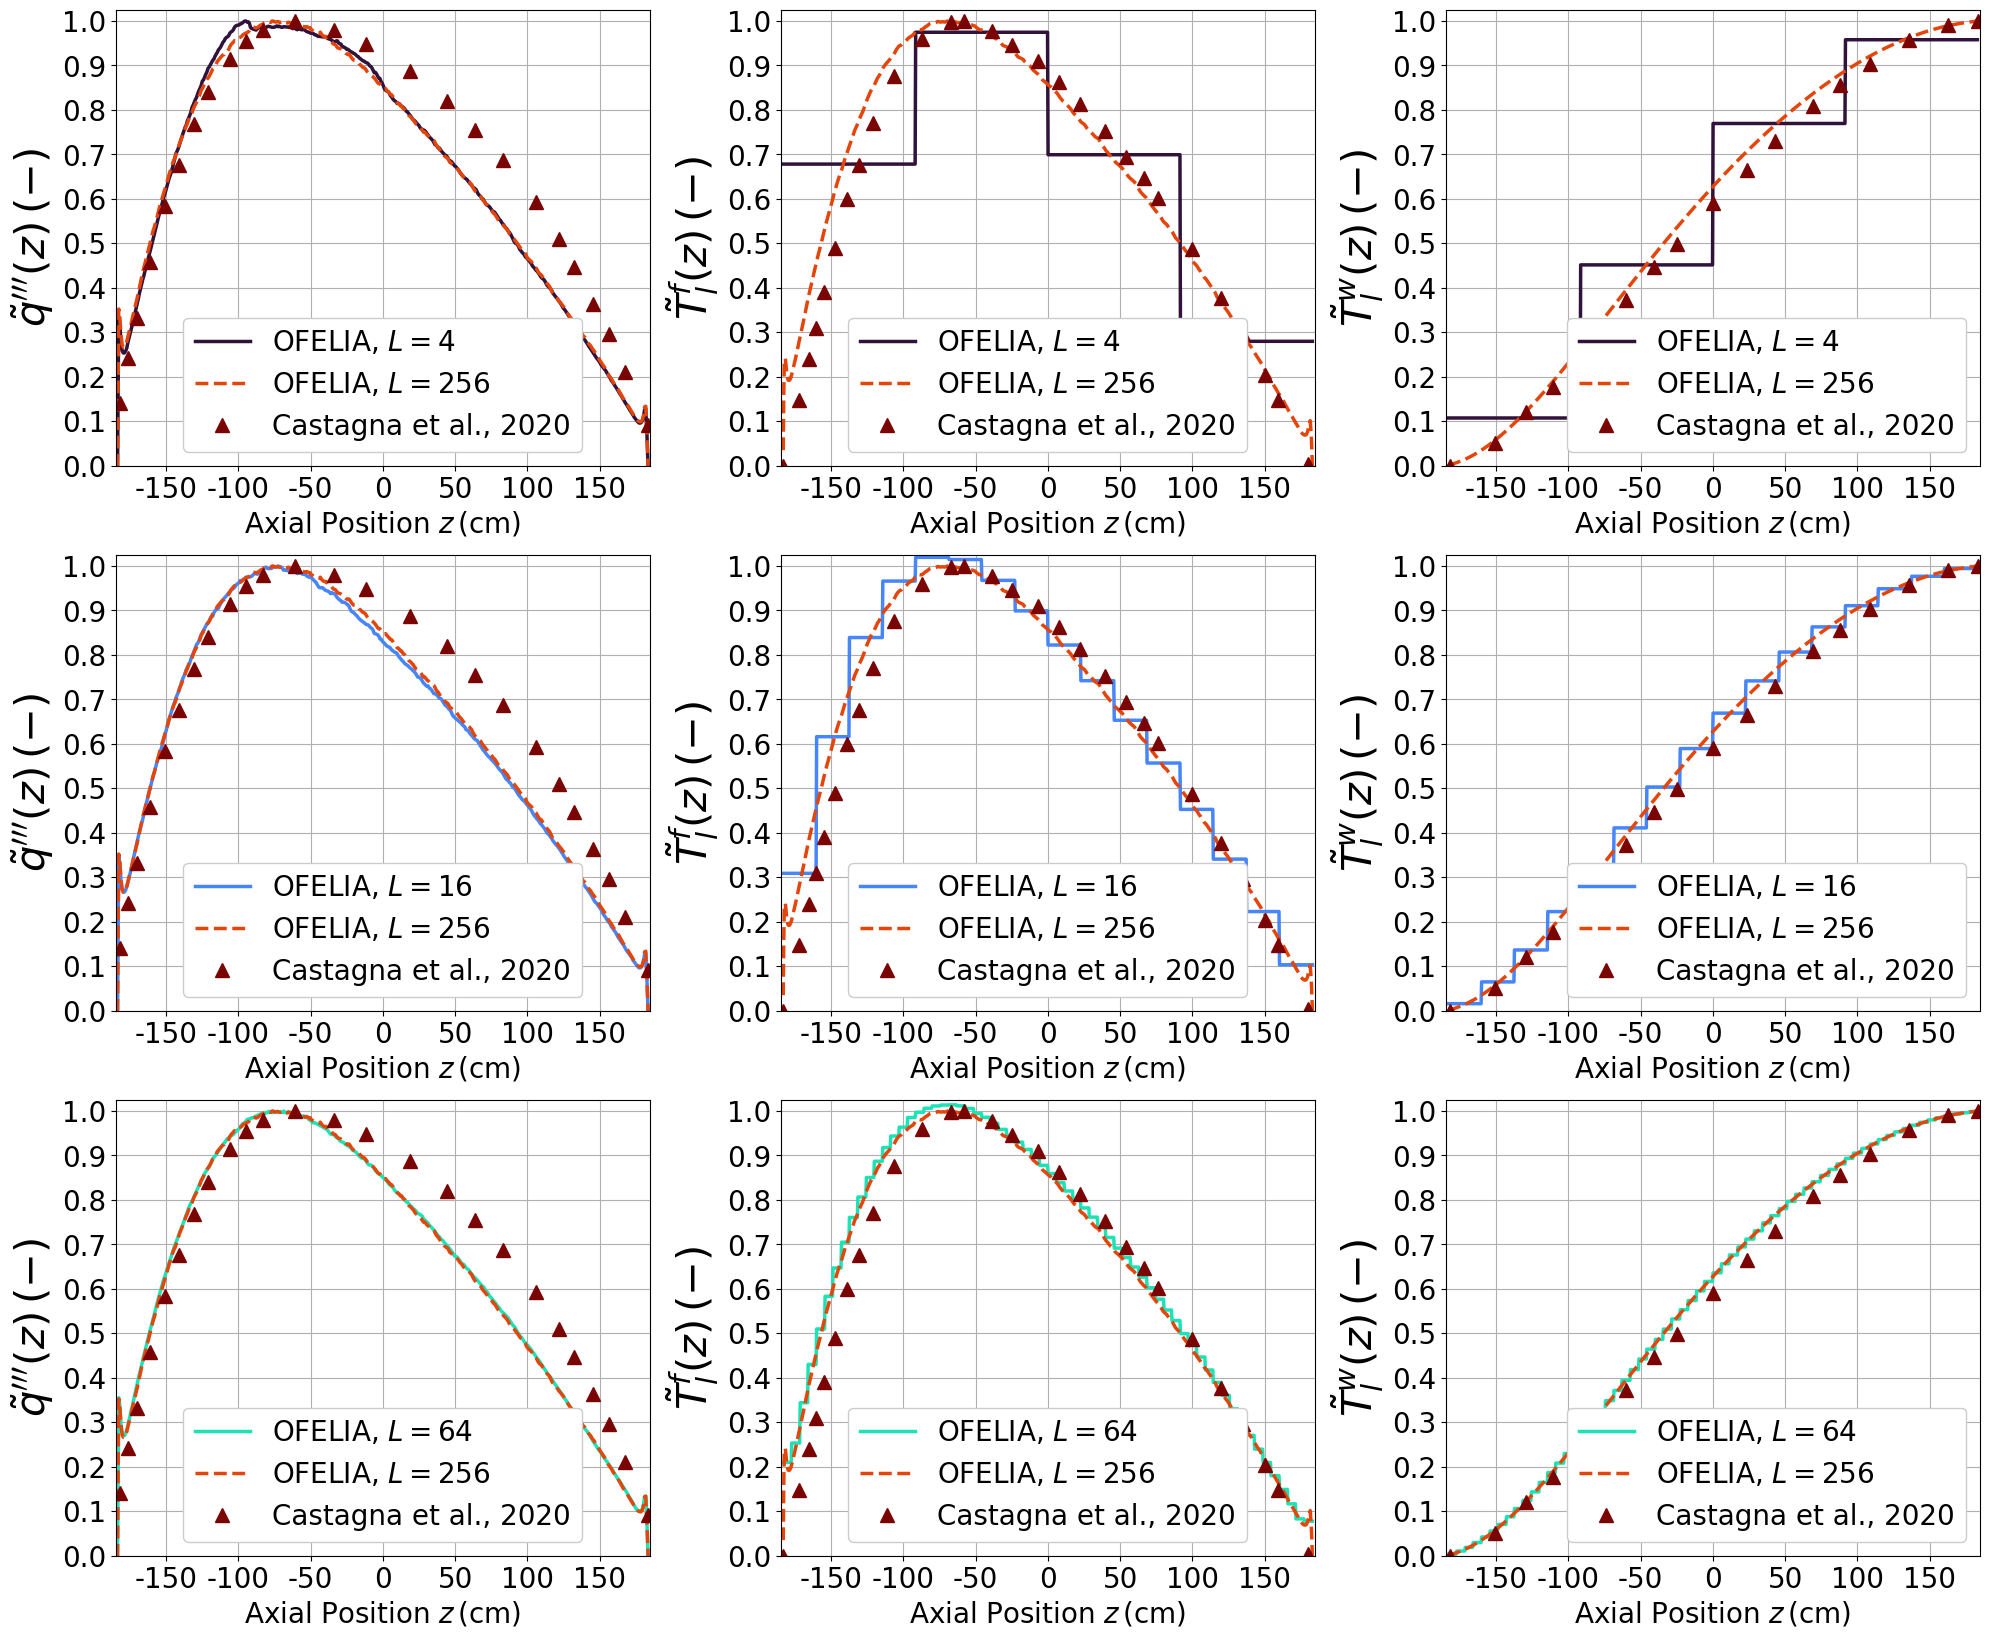

In [7]:
fig = plt.figure(figsize=(20,(len(n_div_to_plot)-1)*5.5))
gs = fig.add_gridspec(len(n_div_to_plot)-1, 3)
axs = (gs.subplots(sharex='row')).flatten()

colors = cm.turbo(np.linspace(0., 1, len(n_div_to_plot)+3))

for ii in range(len(n_div_to_plot)-1):
    
    z = axial_qties[ii]['z']
    
    # Power density
    ax = axs[ii * 3]
    # ax.plot(single_physics['z'], normalize_power(single_physics['axial_q3'](single_physics['z'])), '-.', color = colors[-3], linewidth=2.5, label='De-Coupled')
    ax.plot(z, normalize_power(axial_qties[ii]['axial_q3'](z)), color = colors[ii], linewidth=2.5, label='OFELIA, $L='+str(n_div_to_plot[ii])+'$')
    ax.plot(z, normalize_power(axial_qties[-1]['axial_q3'](z)), '--', color = colors[-2], linewidth=2.5, label='OFELIA, $L='+str(n_div_to_plot[-1])+'$')
    ax.plot(castagna_res['fission_rate'][:,0]-L_active/2, normalize_power(castagna_res['fission_rate'][:,1]), '^', markersize = 10, color = colors[-1], linewidth=2.5, label='Castagna et al., 2020')
    
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')
    ax.set_ylabel(r"$\tilde{q}'''(z)\,\left(-\right)$", fontsize=30)
    ax.set_ylim(0, 1.025)
    ax.set_xlim(-L_active/2*1.01, L_active/2*1.01)
    ax.set_yticks(np.arange(0, 1.05, 0.1))
    ax.set_yticklabels(np.round(np.arange(0, 1.05, 0.1), decimals=1),fontsize=20)
    ax.set_xticks(np.arange(-150, 151, 50))
    ax.set_xticklabels(np.arange(-150, 151, 50), fontsize=20)
    ax.set_xlabel(r'Axial Position $z\,$(cm)', fontsize=20)
    ax.legend(fontsize=20, loc = 'lower center', framealpha=1)
    
    # Fuel Temperature
    ax = axs[ii*3+1]
    ax.set_xlabel(r'Axial Position $z\,$(cm)', fontsize=20)
    ax.set_xticks(np.arange(-150, 151, 50))
    ax.set_xticklabels(np.arange(-150, 151, 50), fontsize=20)
    ax.xaxis.grid(True)
    z = np.linspace(-L_active/2, L_active/2, 1000)
    ave_fun = np.zeros_like(z)

    for jj in range(len(slices[ii])-1):
        bounds = np.array([slices[ii][jj], slices[ii][jj+1]])
        ave_fun += np.piecewise(z, [z<bounds[0],
                                np.logical_and(z>=bounds[0], z<=bounds[1]),
                                z>bounds[1]],
                                [0., averages[ii]['Fuel'][jj]-273.15, 0.])

    # T_ax = compute_axial(single_physics['z'], single_physics['2d_data'])
    # ax.plot(single_physics['z'], normalize_temperature(T_ax-273.15), '-.', color = colors[-3], linewidth=2.5, label='De-Coupled')
    
    T_ax = compute_axial(z, data_2d[-1])
    ax.plot(z, normalize_ave_temperature(ave_fun, T_ax-273.15), '-', color = colors[ii], linewidth=2.5, label='OFELIA, $L='+str(n_div_to_plot[ii])+'$')
    ax.plot(z, normalize_temperature(T_ax-273.15),'--', color = colors[-2], linewidth=2.5, label='OFELIA, $L='+str(n_div_to_plot[-1])+'$')
    ax.plot(castagna_res['fuel_temp'][:,0]-L_active/2, normalize_temperature(castagna_res['fuel_temp'][:,1]), '^', color = colors[-1], markersize = 10, linewidth=2.5, label='Castagna et al., 2020')
    ax.set_ylabel(r"$\tilde{T}_l^f(z)\,(-)$", fontsize=30)
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')

    ax.set_ylim(0, 1.025)
    ax.set_xlim(-L_active/2*1.01, L_active/2*1.01)
    ax.set_yticks(np.arange(0, 1.05, 0.1))
    ax.set_yticklabels(np.round(np.arange(0, 1.05, 0.1), decimals=1),fontsize=20)
    ax.legend(fontsize=20, loc = 'lower center', framealpha=1)

    # Water Temperature
    ax = axs[ii*3+2]
    ax.set_xlabel(r'Axial Position $z\,$(cm)', fontsize=20)
    ax.set_xticks(np.arange(-150, 151, 50))
    ax.set_xticklabels(np.arange(-150, 151, 50), fontsize=20)
    ax.xaxis.grid(True)
    z = np.linspace(-L_active/2, L_active/2, 1000)
    ave_fun = np.zeros_like(z)

    for jj in range(len(slices[ii])-1):
        bounds = np.array([slices[ii][jj], slices[ii][jj+1]])
        ave_fun += np.piecewise(z, [z<bounds[0],
                                np.logical_and(z>=bounds[0], z<=bounds[1]),
                                z>bounds[1]],
                                [0., averages[ii]['Water'][jj]-273.15, 0.])
        
    # ax.plot(single_physics['z'], normalize_temperature(single_physics['axial_Tb'](single_physics['z'])-273.15), '-.', color = colors[-3], linewidth=2.5, label='De-Coupled')
    ax.plot(z,normalize_ave_temperature(ave_fun, axial_qties[-1]['axial_Tb'](z)-273.15), '-', color = colors[ii], linewidth=2.5, label='OFELIA, $L='+str(n_div_to_plot[ii])+'$')
    ax.plot(z, normalize_temperature(axial_qties[-1]['axial_Tb'](z)-273.15), '--', color = colors[-2], linewidth=2.5, label='OFELIA, $L='+str(n_div_to_plot[-1])+'$')
    ax.plot(castagna_res['coolant_temp'][:,0]-L_active/2, normalize_temperature(castagna_res['coolant_temp'][:,1]), '^', markersize = 10, color = colors[-1], linewidth=2.5, label='Castagna et al., 2020')
    
    ax.set_ylabel(r"$\tilde{T}_l^w(z)\,(-)$", fontsize=30)
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')
    
    ax.set_ylim(0, 1.025)
    ax.set_xlim(-L_active/2*1.01, L_active/2*1.01)
    ax.set_yticks(np.arange(0, 1.05, 0.1))
    ax.set_yticklabels(np.round(np.arange(0, 1.05, 0.1), decimals=1),fontsize=20)
    ax.legend(fontsize=20, loc = 'lower right', framealpha=1)
    
plt.tight_layout()
fig.savefig('AxialPlot_pow_fuel_wat_normalised.pdf', format='pdf', dpi=300, bbox_inches='tight')

## Single Figure: fuel and water T

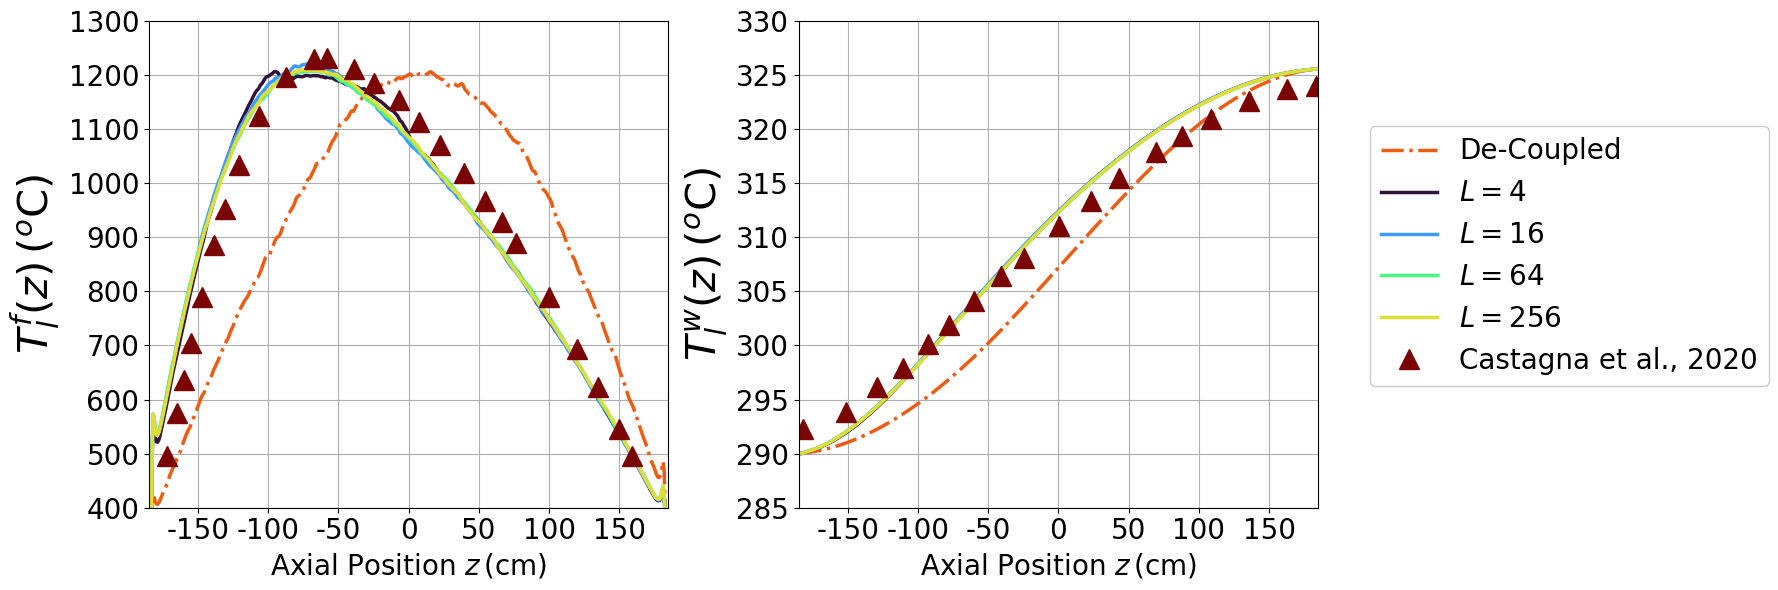

In [8]:
colors = cm.turbo(np.linspace(0., 1, len(n_div_to_plot)+2))

fig = plt.figure(figsize=(18,6))
gs = fig.add_gridspec(1, 2)
axs = (gs.subplots(sharex='row')).flatten()

# Fuel temperature
ax = axs[0]
ax.set_xlabel(r'Axial Position $z\,$(cm)', fontsize=20)
ax.set_xticks(np.arange(-150, 151, 50))
ax.set_xticklabels(np.arange(-150, 151, 50), fontsize=20)
ax.xaxis.grid(True)

T_ax = compute_axial(single_physics['z'], single_physics['2d_data'], centreline=True)
ax.plot(single_physics['z'], T_ax-273.15, '-.', color = colors[-2], linewidth=2.5, label='De-Coupled')
    
for ii in range(len(n_div_to_plot)):
    T_ax = compute_axial(axial_qties[ii]['z'], data_2d[ii], centreline=True)
    ax.plot(axial_qties[ii]['z'], T_ax-273.15, color = colors[ii], linewidth=2.5, label='$L='+str(n_div_to_plot[ii])+'$')
ax.plot(castagna_res['fuel_temp'][:,0]-L_active/2, castagna_res['fuel_temp'][:,1] - 273.15, '^', 
        color = colors[-1], markersize = mark_size, linewidth=lw, label='Castagna et al., 2020')

ax.set_ylabel(r"$T_l^f(z)\,(^o\text{C})$", fontsize=30)
ax.grid(which='major',linestyle='-')
ax.grid(which='minor',linestyle='--')

ax.set_ylim(400, 1300)
ax.set_xlim(-L_active/2*1.01, L_active/2*1.01)
ax.set_yticks(np.arange(400, 1301, 100))
ax.set_yticklabels(np.arange(400, 1301, 100),fontsize=20)
# ax.legend(fontsize=20, loc = 'lower center', framealpha=1, ncols = 2)

# Water temperature
ax = axs[1]
ax.set_xlabel(r'Axial Position $z\,$(cm)', fontsize=20)
ax.set_xticks(np.arange(-150, 151, 50))
ax.set_xticklabels(np.arange(-150, 151, 50), fontsize=20)
ax.xaxis.grid(True)
z = np.linspace(-L_active/2, L_active/2, 1000)
    
ax.plot(single_physics['z'], single_physics['axial_Tb'](single_physics['z'])-273.15, '-.', color = colors[-2], linewidth=2.5, label='De-Coupled')

for ii in range(len(n_div_to_plot)):
    ax.plot(axial_qties[ii]['z'], axial_qties[ii]['axial_Tb'](axial_qties[ii]['z'])-273.15, color = colors[ii], linewidth=2.5, label='$L='+str(n_div_to_plot[ii])+'$')
ax.plot(castagna_res['coolant_temp'][:,0]-L_active/2, castagna_res['coolant_temp'][:,1]-273.15, '^', markersize = mark_size, color = colors[-1], linewidth=lw, label='Castagna et al., 2020')

ax.set_ylabel(r"$T_l^w(z)\,(^o\text{C})$", fontsize=30)
ax.grid(which='major',linestyle='-')
ax.grid(which='minor',linestyle='--')

ax.set_xlim(-L_active/2*1.01, L_active/2*1.01)
ax.set_yticks(np.arange(285, 331, 5))
ax.set_yticklabels(np.arange(285, 331, 5), fontsize=20)
ax.set_ylim(285, 330)
ax.legend(fontsize=20, loc = (1.1, 0.25), framealpha=1)


plt.tight_layout()
fig.savefig('Axial_Plot_Fuel_Water.pdf', format='pdf', dpi=300, bbox_inches='tight')

## Separate figure - fuel and water

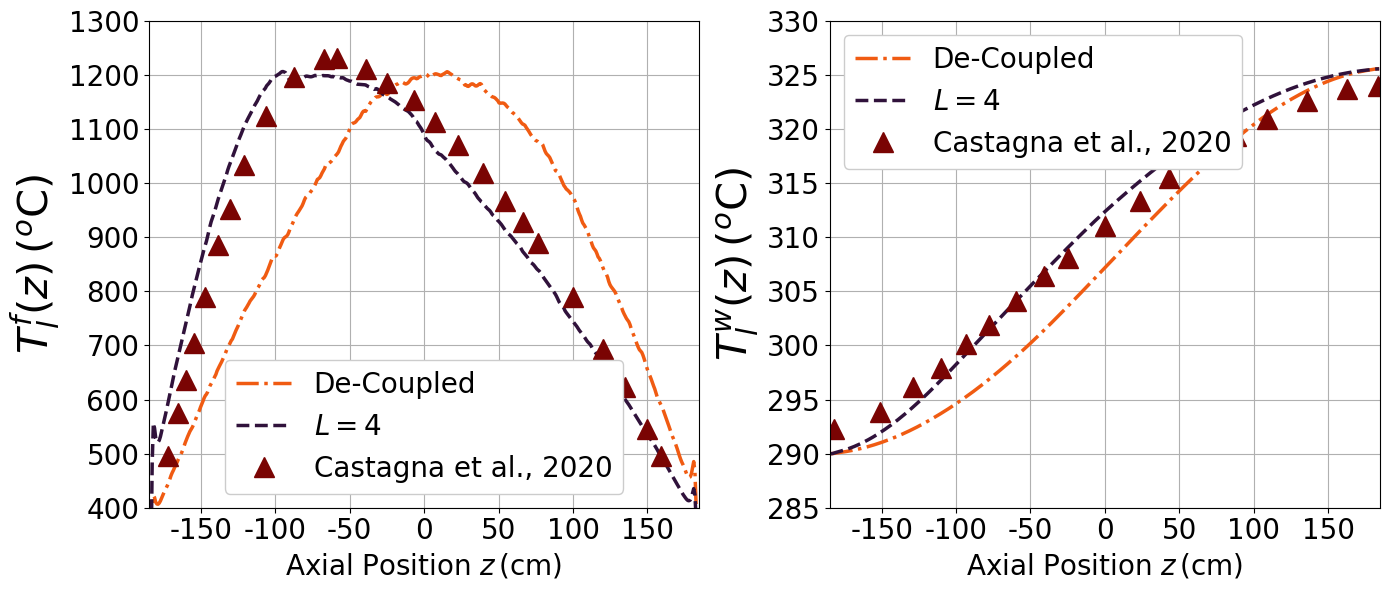

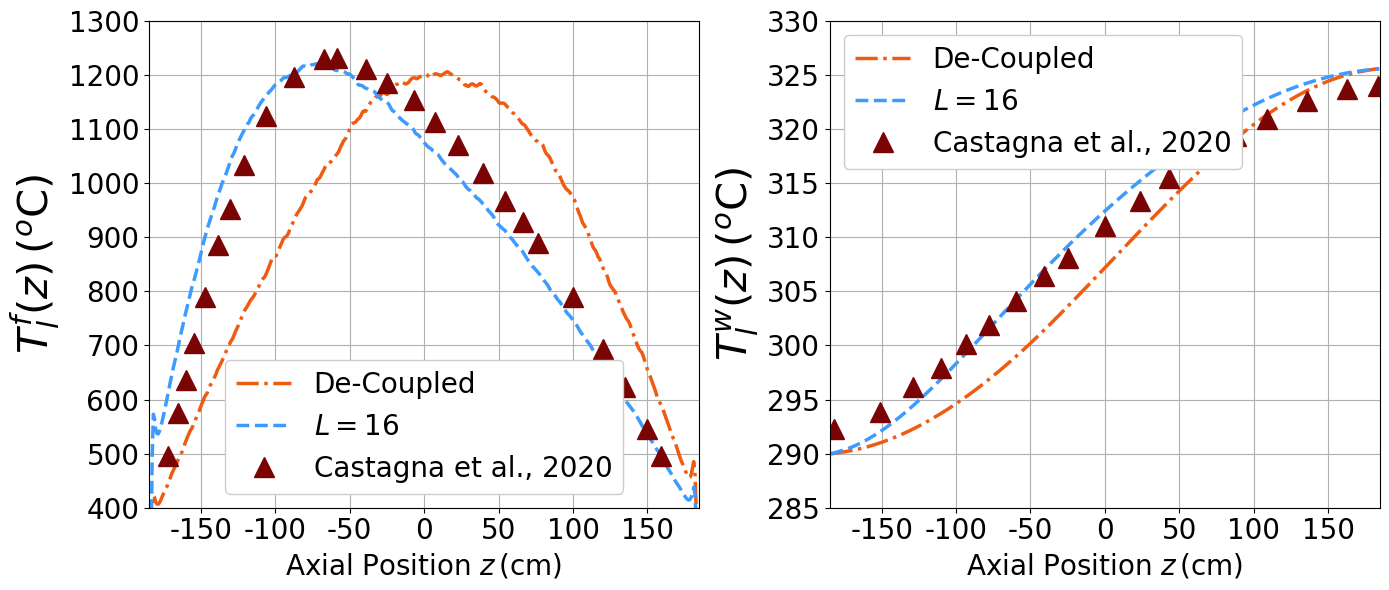

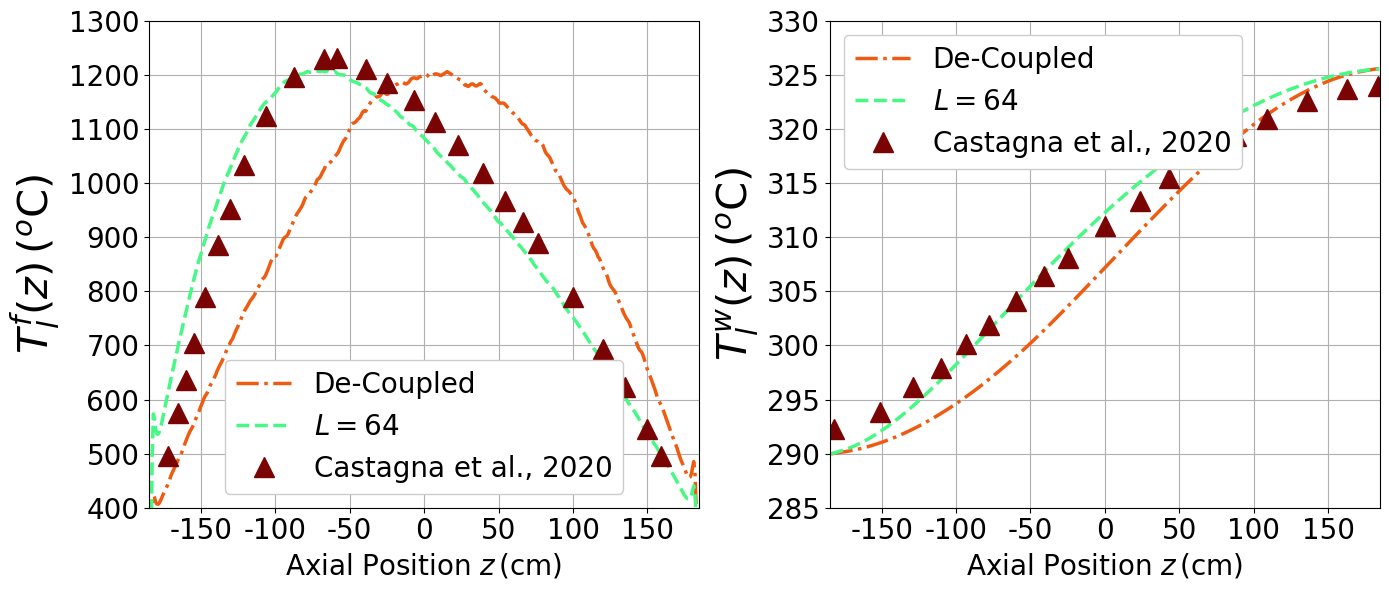

In [9]:
colors = cm.turbo(np.linspace(0., 1, len(n_div_to_plot)+2))

for ii in range(len(n_div_to_plot)-1):
    fig = plt.figure(figsize=(14,6))
    gs = fig.add_gridspec(1, 2)
    axs = (gs.subplots(sharex='row')).flatten()
    
    # Fuel temperature
    ax = axs[0]
    ax.set_xlabel(r'Axial Position $z\,$(cm)', fontsize=20)
    ax.set_xticks(np.arange(-150, 151, 50))
    ax.set_xticklabels(np.arange(-150, 151, 50), fontsize=20)
    ax.xaxis.grid(True)

    T_ax = compute_axial(single_physics['z'], single_physics['2d_data'], centreline=True)
    ax.plot(single_physics['z'], T_ax-273.15, '-.', color = colors[-2], linewidth=2.5, label='De-Coupled')
        
    T_ax = compute_axial(axial_qties[ii]['z'], data_2d[ii], centreline=True)
    ax.plot(axial_qties[ii]['z'], T_ax-273.15,'--', color = colors[ii], linewidth=2.5, label='$L='+str(n_div_to_plot[ii])+'$')
    ax.plot(castagna_res['fuel_temp'][:,0]-L_active/2, castagna_res['fuel_temp'][:,1] - 273.15, '^', 
            color = colors[-1], markersize = mark_size, linewidth=lw, label='Castagna et al., 2020')
    
    ax.set_ylabel(r"$T_l^f(z)\,(^o\text{C})$", fontsize=30)
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')

    ax.set_ylim(400, 1300)
    ax.set_xlim(-L_active/2*1.01, L_active/2*1.01)
    ax.set_yticks(np.arange(400, 1301, 100))
    ax.set_yticklabels(np.arange(400, 1301, 100),fontsize=20)
    ax.legend(fontsize=20, loc = 'lower center', framealpha=1)

    # Water temperature
    ax = axs[1]
    ax.set_xlabel(r'Axial Position $z\,$(cm)', fontsize=20)
    ax.set_xticks(np.arange(-150, 151, 50))
    ax.set_xticklabels(np.arange(-150, 151, 50), fontsize=20)
    ax.xaxis.grid(True)
    z = np.linspace(-L_active/2, L_active/2, 1000)
        
    ax.plot(single_physics['z'], single_physics['axial_Tb'](single_physics['z'])-273.15, '-.', color = colors[-2], linewidth=2.5, label='De-Coupled')
    ax.plot(axial_qties[ii]['z'], axial_qties[ii]['axial_Tb'](axial_qties[ii]['z'])-273.15, '--', color = colors[ii], linewidth=2.5, label='$L='+str(n_div_to_plot[ii])+'$')
    ax.plot(castagna_res['coolant_temp'][:,0]-L_active/2, castagna_res['coolant_temp'][:,1]-273.15, '^', markersize = mark_size, color = colors[-1], linewidth=lw, label='Castagna et al., 2020')
    
    ax.set_ylabel(r"$T_l^w(z)\,(^o\text{C})$", fontsize=30)
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')
    
    ax.set_xlim(-L_active/2*1.01, L_active/2*1.01)
    ax.set_yticks(np.arange(285, 331, 5))
    ax.set_yticklabels(np.arange(285, 331, 5), fontsize=20)
    ax.set_ylim(285, 330)
    ax.legend(fontsize=20, loc = 'upper left', framealpha=1)
    
    
    plt.tight_layout()
    fig.savefig('AxialPlot_sep_'+str(ii)+'.pdf', format='pdf', dpi=300, bbox_inches='tight')

## Separate figure - fuel, power, and water - normalised

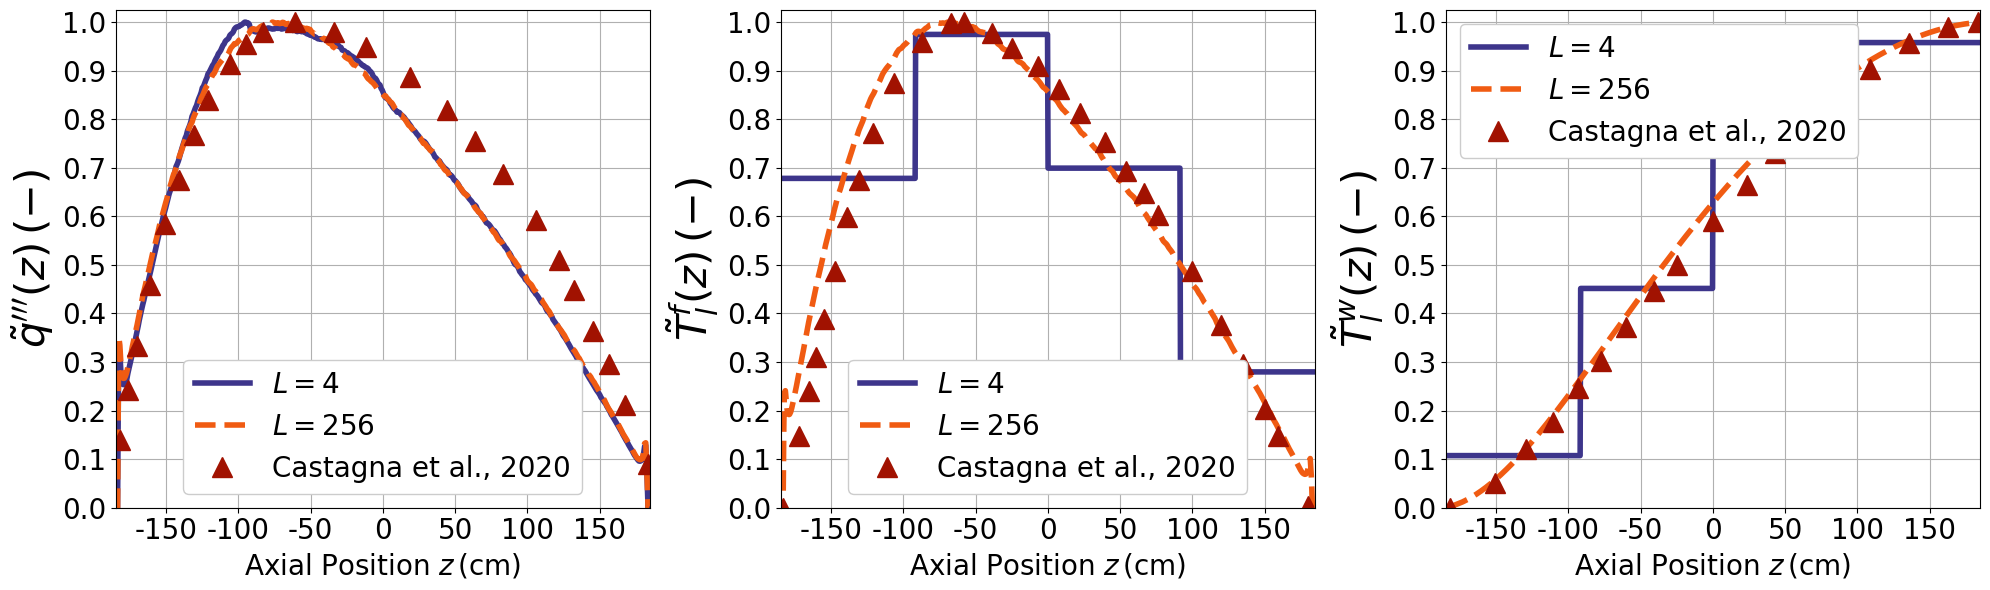

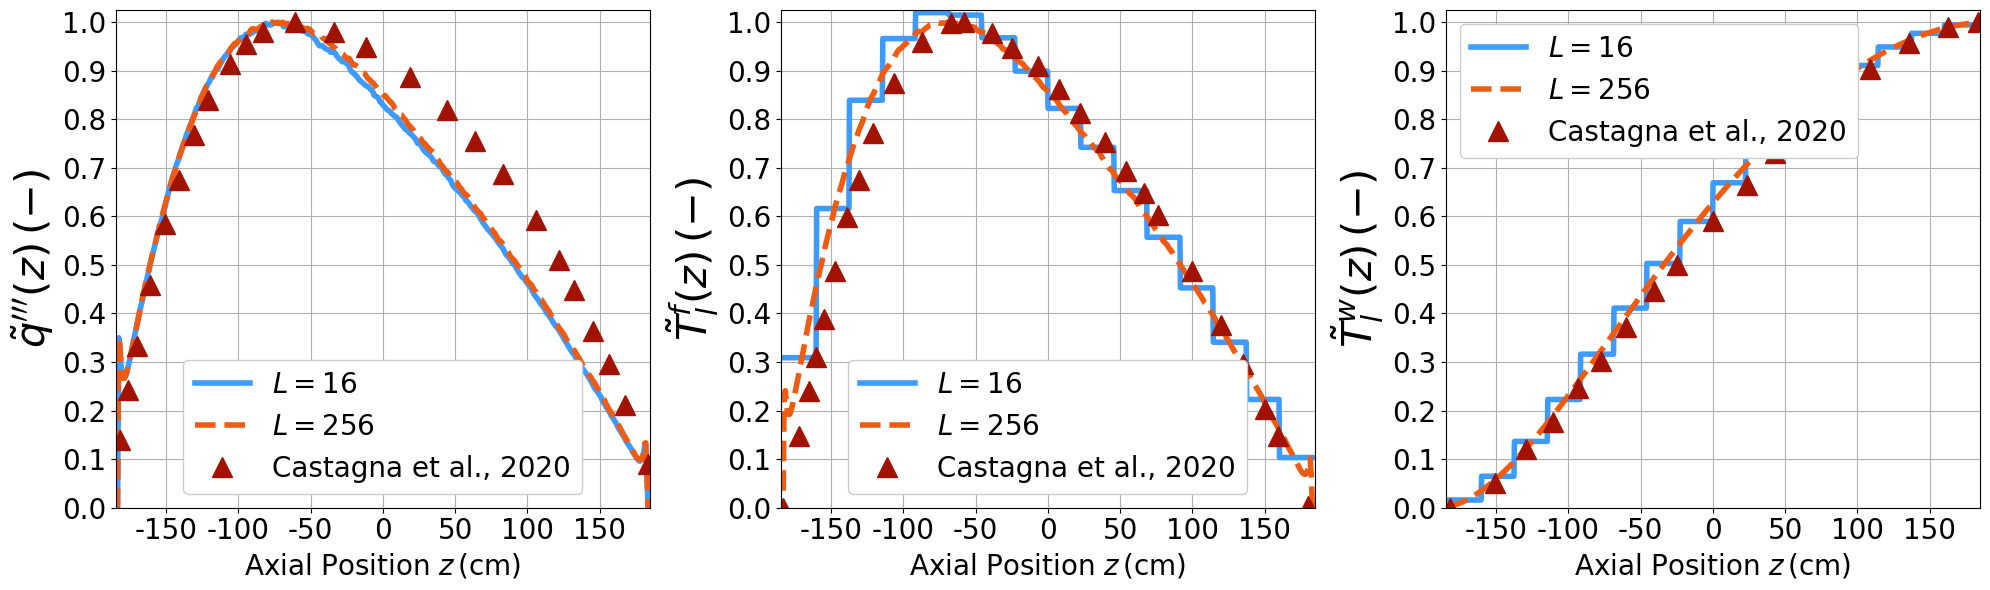

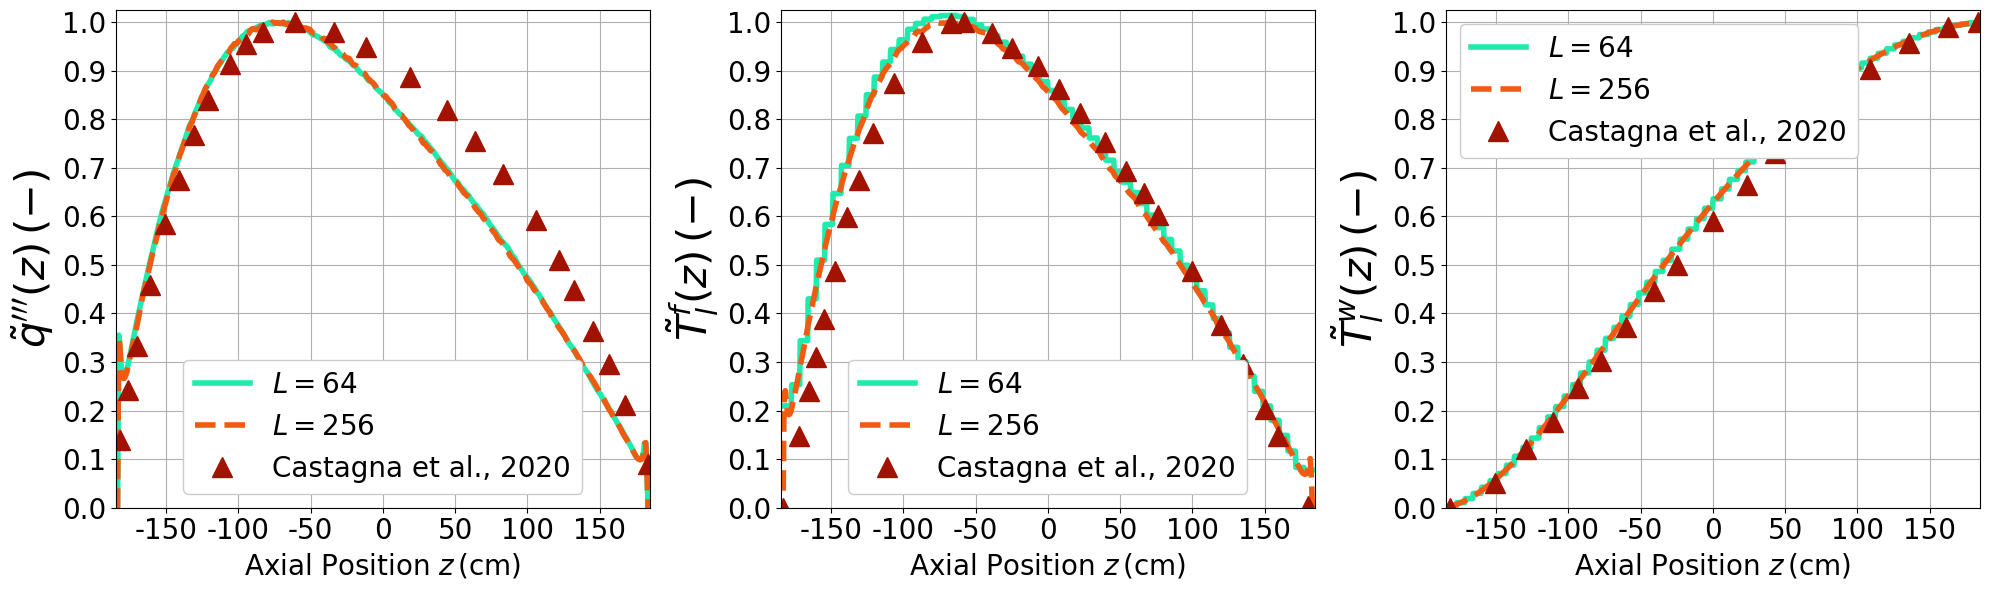

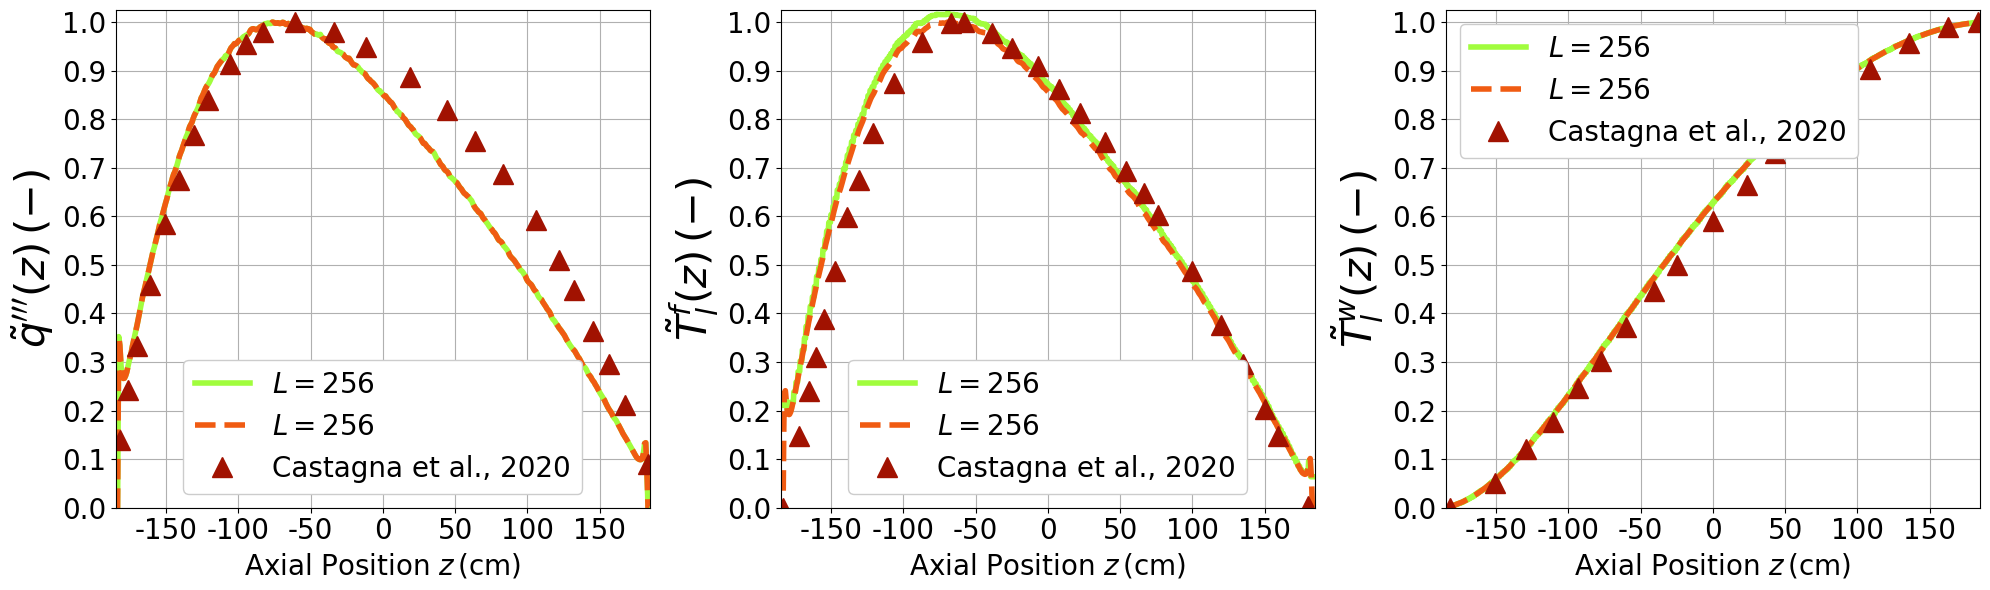

In [10]:
colors = cm.turbo(np.linspace(0.05, .95, len(n_div_to_plot)+3))

for ii in range(4):
    fig = plt.figure(figsize=(20,6))
    gs = fig.add_gridspec(1, 3)
    axs = (gs.subplots(sharex='row')).flatten()
    
    z = axial_qties[ii]['z']
    
    # Power density
    ax = axs[0]
    # ax.plot(single_physics['z'], normalize_power(single_physics['axial_q3'](single_physics['z'])), '-.', color = colors[-3], linewidth=lw, label='De-Coupled')
    ax.plot(z, normalize_power(axial_qties[ii]['axial_q3'](z)), color = colors[ii], linewidth=lw, label='$L='+str(n_div_to_plot[ii])+'$')
    ax.plot(z, normalize_power(axial_qties[-1]['axial_q3'](z)), '--', color = colors[-2], linewidth=lw, label='$L='+str(n_div_to_plot[-1])+'$')
    ax.plot(castagna_res['fission_rate'][:,0]-L_active/2, normalize_power(castagna_res['fission_rate'][:,1]), '^', markersize = mark_size, color = colors[-1], linewidth=lw, label='Castagna et al., 2020')
    
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')
    ax.set_ylabel(r"$\tilde{q}'''(z)\,\left(-\right)$", fontsize=30)
    ax.set_ylim(0, 1.025)
    ax.set_xlim(-L_active/2*1.01, L_active/2*1.01)
    ax.set_yticks(np.arange(0, 1.05, 0.1))
    ax.set_yticklabels(np.round(np.arange(0, 1.05, 0.1), decimals=1),fontsize=20)
    ax.set_xticks(np.arange(-150, 151, 50))
    ax.set_xticklabels(np.arange(-150, 151, 50), fontsize=20)
    ax.set_xlabel(r'Axial Position $z\,$(cm)', fontsize=20)
    ax.legend(fontsize=20, loc = 'lower center', framealpha=1)
    
    # Fuel Temperature
    ax = axs[1]
    ax.set_xlabel(r'Axial Position $z\,$(cm)', fontsize=20)
    ax.set_xticks(np.arange(-150, 151, 50))
    ax.set_xticklabels(np.arange(-150, 151, 50), fontsize=20)
    ax.xaxis.grid(True)
    z = np.linspace(-L_active/2, L_active/2, 1000)
    ave_fun = np.zeros_like(z)

    for jj in range(len(slices[ii])-1):
        bounds = np.array([slices[ii][jj], slices[ii][jj+1]])
        ave_fun += np.piecewise(z, [z<bounds[0],
                                np.logical_and(z>=bounds[0], z<=bounds[1]),
                                z>bounds[1]],
                                [0., averages[ii]['Fuel'][jj]-273.15, 0.])

    # T_ax = compute_axial(single_physics['z'], single_physics['2d_data'])
    # ax.plot(single_physics['z'], normalize_temperature(T_ax-273.15), '-.', color = colors[-3], linewidth=lw, label='De-Coupled')
    
    T_ax = compute_axial(z, data_2d[-1])
    ax.plot(z, normalize_ave_temperature(ave_fun, T_ax-273.15), '-', color = colors[ii], linewidth=lw, label='$L='+str(n_div_to_plot[ii])+'$')
    ax.plot(z, normalize_temperature(T_ax-273.15),'--', color = colors[-2], linewidth=lw, label='$L='+str(n_div_to_plot[-1])+'$')
    ax.plot(castagna_res['fuel_temp'][:,0]-L_active/2, normalize_temperature(castagna_res['fuel_temp'][:,1]), '^', color = colors[-1], markersize = mark_size, linewidth=lw, label='Castagna et al., 2020')
    
    ax.set_ylabel(r"$\tilde{T}_l^f(z)\,(-)$", fontsize=30)
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')

    ax.set_ylim(0, 1.025)
    ax.set_xlim(-L_active/2*1.01, L_active/2*1.01)
    ax.set_yticks(np.arange(0, 1.05, 0.1))
    ax.set_yticklabels(np.round(np.arange(0, 1.05, 0.1), decimals=1),fontsize=20)
    ax.legend(fontsize=20, loc = 'lower center', framealpha=1)

    # Water Temperature
    ax = axs[2]
    ax.set_xlabel(r'Axial Position $z\,$(cm)', fontsize=20)
    ax.set_xticks(np.arange(-150, 151, 50))
    ax.set_xticklabels(np.arange(-150, 151, 50), fontsize=20)
    ax.xaxis.grid(True)
    z = np.linspace(-L_active/2, L_active/2, 1000)
    ave_fun = np.zeros_like(z)

    for jj in range(len(slices[ii])-1):
        bounds = np.array([slices[ii][jj], slices[ii][jj+1]])
        ave_fun += np.piecewise(z, [z<bounds[0],
                                np.logical_and(z>=bounds[0], z<=bounds[1]),
                                z>bounds[1]],
                                [0., averages[ii]['Water'][jj]-273.15, 0.])
        
    # ax.plot(single_physics['z'], normalize_temperature(single_physics['axial_Tb'](single_physics['z'])-273.15), '-.', color = colors[-3], linewidth=lw, label='De-Coupled')
    ax.plot(z,normalize_ave_temperature(ave_fun, axial_qties[-1]['axial_Tb'](z)-273.15), '-', color = colors[ii], linewidth=lw, label='$L='+str(n_div_to_plot[ii])+'$')
    ax.plot(z, normalize_temperature(axial_qties[-1]['axial_Tb'](z)-273.15), '--', color = colors[-2], linewidth=lw, label='$L='+str(n_div_to_plot[-1])+'$')
    ax.plot(castagna_res['coolant_temp'][:,0]-L_active/2, normalize_temperature(castagna_res['coolant_temp'][:,1]), '^', markersize = mark_size, color = colors[-1], linewidth=lw, label='Castagna et al., 2020')
    
    ax.set_ylabel(r"$\tilde{T}_l^w(z)\,(-)$", fontsize=30)
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')
    
    ax.set_ylim(0, 1.025)
    ax.set_xlim(-L_active/2*1.01, L_active/2*1.01)
    ax.set_yticks(np.arange(0, 1.05, 0.1))
    ax.set_yticklabels(np.round(np.arange(0, 1.05, 0.1), decimals=1),fontsize=20)
    ax.legend(fontsize=20, loc = 'upper left', framealpha=1)
    
    plt.tight_layout()
    fig.savefig('AxialPlot_full_normalised_'+str(ii)+'.pdf', format='pdf', dpi=300, bbox_inches='tight')

## Contour Plot

/var/folders/b2/g0q33k1j11s7_tm3xz99k4bh0000gn/T/ipykernel_4836/1481322070.py:14: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for contour in cont.collections:
/var/folders/b2/g0q33k1j11s7_tm3xz99k4bh0000gn/T/ipykernel_4836/1481322070.py:14: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for contour in cont.collections:


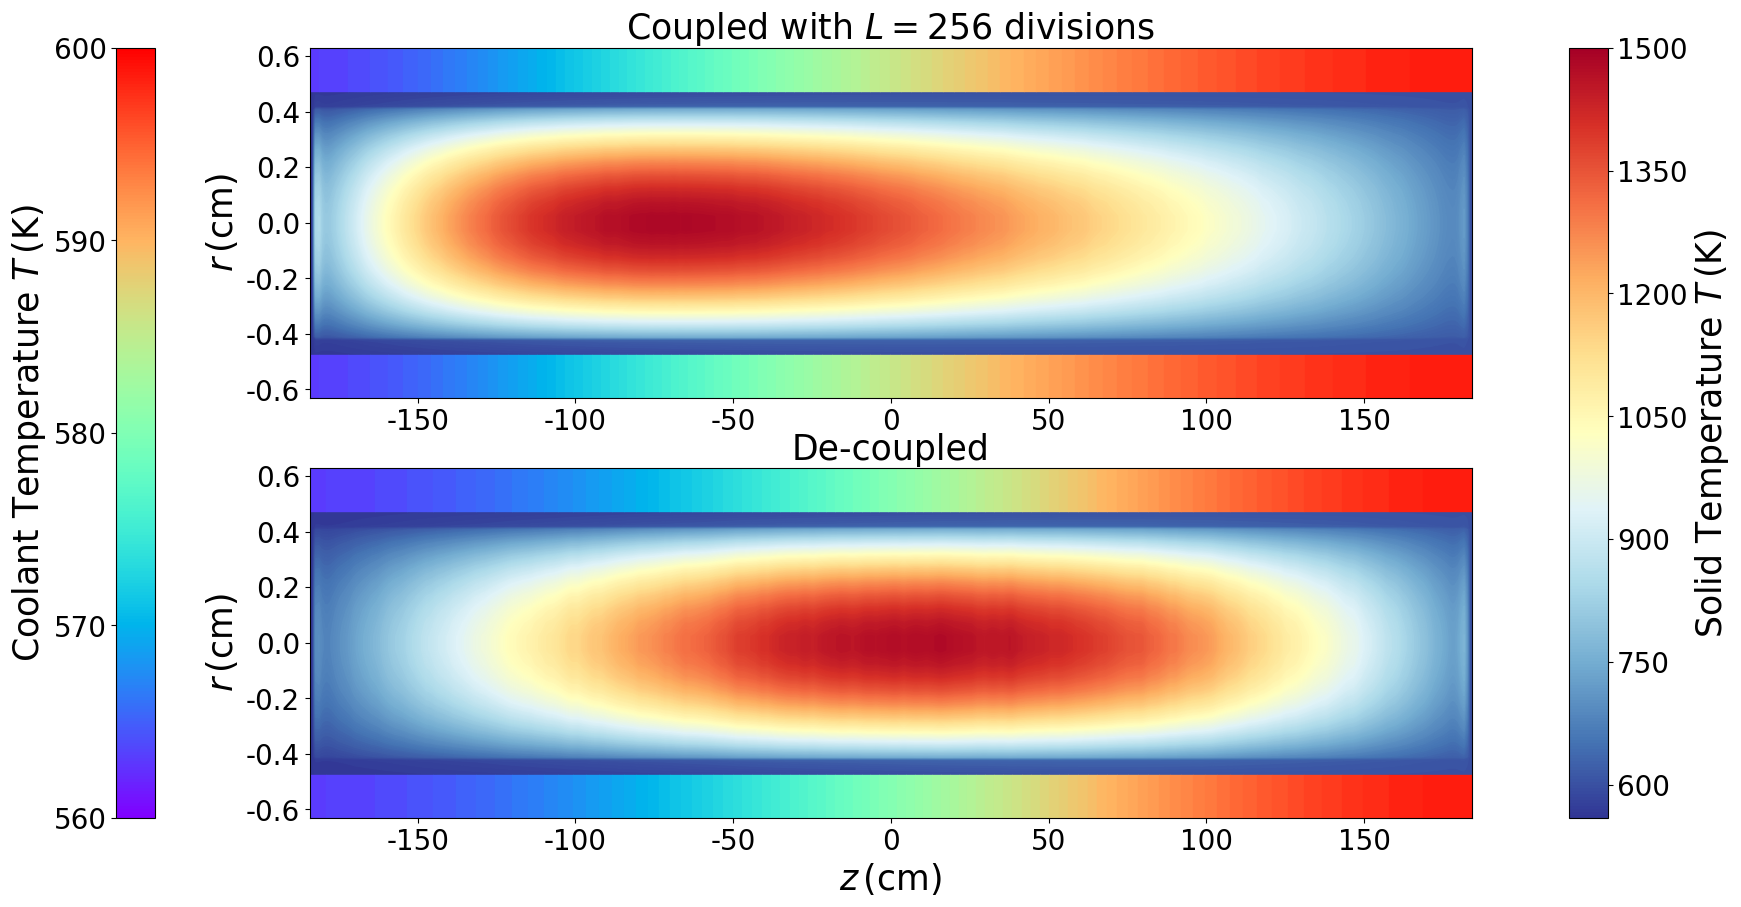

In [11]:
coolant_radius_1d_down = np.linspace(data_2d[-1]['Y'].max(), 1.26 / 2)
coolant_radius_1d_up   = np.linspace(-1.26/2, data_2d[-1]['Y'].min())
coolant_axial_1d  = axial_qties[-1]['z']

Z_down, R_down = np.meshgrid(coolant_axial_1d, coolant_radius_1d_down)
Z_up, R_up     = np.meshgrid(coolant_axial_1d, coolant_radius_1d_up)

T_solid_limits   = [560, 1500]
T_coolant_limits = [560, 600]
cmap_solid   = cm.RdYlBu_r
cmap_coolant = cm.rainbow

def remove_iso(cont):
    for contour in cont.collections:
        contour.set_edgecolor("face")
        
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25,10))

contour_plot = axes[0].contourf(data_2d[-1]['X'], data_2d[-1]['Y'], data_2d[-1]['T'].T, 
                                levels = np.linspace(*T_solid_limits, 200), cmap = cmap_solid)

T_coolant_interp = lambda r, z: axial_qties[-1]['axial_Tb'](z)
T_coolant_down = T_coolant_interp(R_down, Z_down)
T_coolant_up   = T_coolant_interp(R_up, Z_up)

contour_plot_cool_down = axes[0].contourf(Z_down, R_down, T_coolant_down, 
                                          levels = np.linspace(*T_coolant_limits, 100), cmap = cmap_coolant)
contour_plot_cool_up   = axes[0].contourf(Z_up, R_up, T_coolant_up, 
                                          levels = np.linspace(*T_coolant_limits, 100), cmap = cmap_coolant)

axes[0].set_ylabel(r'$r\,$(cm)', fontsize=25)
axes[0].set_xticks(np.arange(-150, 151, 50))
axes[0].set_xticklabels(np.arange(-150, 151, 50), fontsize=20)
axes[0].set_yticks(np.arange(-0.6, 0.61, 0.2))
axes[0].set_yticklabels(np.round(np.arange(-0.6, 0.61, 0.2), decimals=1), fontsize=20)
axes[0].set_title(r'Coupled with $L=256$ divisions', fontsize=25)

# Set contour lines color to match background
remove_iso(contour_plot)
remove_iso(contour_plot_cool_down)
remove_iso(contour_plot_cool_up)
##########################################################################################

contour_plot2 = axes[1].contourf(single_physics['2d_data']['X'], single_physics['2d_data']['Y'], single_physics['2d_data']['T'].T, 
                                levels = np.linspace(*T_solid_limits, 200), cmap = cmap_solid)

coolant_radius_1d_down2 = np.linspace(single_physics['2d_data']['Y'].max(), 1.26 / 2)
coolant_radius_1d_up2   = np.linspace(-1.26/2, single_physics['2d_data']['Y'].min())
coolant_axial_1d2  = single_physics['z']

Z_down2, R_down2 = np.meshgrid(coolant_axial_1d2, coolant_radius_1d_down2)
Z_up2, R_up2     = np.meshgrid(coolant_axial_1d2, coolant_radius_1d_up2)

T_coolant_interp2 = lambda r, z: single_physics['axial_Tb'](z)
T_coolant_down2 = T_coolant_interp2(R_down2, Z_down2)
T_coolant_up2   = T_coolant_interp2(R_up2, Z_up2)

contour_plot_cool_down2 = axes[1].contourf(Z_down2, R_down2, T_coolant_down2, 
                                          levels = np.linspace(*T_coolant_limits, 100), cmap = cmap_coolant)
contour_plot_cool_up2   = axes[1].contourf(Z_up2, R_up2, T_coolant_up2, 
                                          levels = np.linspace(*T_coolant_limits, 100), cmap = cmap_coolant)

cbar = fig.colorbar(cm.ScalarMappable(norm=contour_plot.norm, cmap=contour_plot.cmap), 
                    ax=axes.ravel().tolist(), location='right',
                    ticks = np.arange(600, T_solid_limits[1]+1, 150))
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r'Solid Temperature $T\,\left(\text{K}\right)$', fontsize=25)

cbar2 = fig.colorbar(cm.ScalarMappable(norm=contour_plot_cool_down2.norm, cmap=contour_plot_cool_down2.cmap), 
                     ax=axes.ravel().tolist(), location='left',
                    ticks = np.arange(T_coolant_limits[0], T_coolant_limits[1]+1, 10))
cbar2.ax.tick_params(labelsize=20)
cbar2.set_label(r'Coolant Temperature $T\,\left(\text{K}\right)$', fontsize=25)

axes[1].set_ylabel(r'$r\,$(cm)', fontsize=25)
axes[1].set_xlabel(r'$z\,$(cm)', fontsize=25)
axes[1].set_xticks(np.arange(-150, 151, 50))
axes[1].set_xticklabels(np.arange(-150, 151, 50), fontsize=20)
axes[1].set_yticks(np.arange(-0.6, 0.61, 0.2))
axes[1].set_yticklabels(np.round(np.arange(-0.6, 0.61, 0.2), decimals=1), fontsize=20)
axes[1].set_title(r'De-coupled', fontsize=25)

# Set contour lines color to match background
remove_iso(contour_plot2)
remove_iso(contour_plot_cool_down2)
remove_iso(contour_plot_cool_up2)

fig.savefig('Contour_temperature_comparison_ppt.pdf', format='pdf', dpi=600, bbox_inches='tight')

No coolant version

In [ ]:
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(45,20))
# # fig = plt.figure(figsize=(16,10))

# contour_plot = axes[0].contourf(data_2d[-1]['X'], data_2d[-1]['Y'], data_2d[-1]['T'].T, 
#                             levels = 200, cmap = cm.coolwarm, vmin=580, vmax=1480)

# # Set contour lines color to match background
# for contour in contour_plot.collections:
#     contour.set_edgecolor("face")

# # cbar = plt.colorbar(cm.ScalarMappable(norm=contour_plot.norm, cmap=contour_plot.cmap), ticks = np.arange(250, 1251, 200))
# # cbar.ax.tick_params(labelsize=25)
# # plt.clim(vmin=250, vmax=1250)

# axes[0].set_ylabel(r'$r\,$(cm)', fontsize=50)
# axes[0].set_xticks(np.arange(-150, 151, 50))
# axes[0].set_xticklabels(np.arange(-150, 151, 50), fontsize=40)
# axes[0].set_yticks(np.arange(-0.4, 0.41, 0.2))
# axes[0].set_yticklabels(np.round(np.arange(-0.4, 0.41, 0.2), decimals=1), fontsize=40)
# axes[0].set_title(r'Coupled with $L=256$ divisions', fontsize=50)

# ##########################################################################################

# contour_plot = axes[1].contourf(single_physics['2d_data']['X'], single_physics['2d_data']['Y'], single_physics['2d_data']['T'].T, 
#                            levels = 200, cmap = cm.coolwarm, vmin=580, vmax=1480)

# # Set contour lines color to match background
# for contour in contour_plot.collections:
#     contour.set_edgecolor("face")

# cbar = fig.colorbar(cm.ScalarMappable(norm=contour_plot.norm, cmap=contour_plot.cmap), ax=axes.ravel().tolist(), 
#                     ticks = np.arange(580, 1481, 150))
# cbar.ax.tick_params(labelsize=40)
# cbar.set_label(r'Temperature $T\,\left(\text{K}\right)$', fontsize=70)

# axes[1].set_ylabel(r'$r\,$(cm)', fontsize=50)
# axes[1].set_xlabel(r'$z\,$(cm)', fontsize=50)
# axes[1].set_xticks(np.arange(-150, 151, 50))
# axes[1].set_xticklabels(np.arange(-150, 151, 50), fontsize=40)
# axes[1].set_yticks(np.arange(-0.4, 0.41, 0.2))
# axes[1].set_yticklabels(np.round(np.arange(-0.4, 0.41, 0.2), decimals=1), fontsize=40)
# axes[1].set_title(r'De-coupled', fontsize=50)

# # plt.tight_layout()

# fig.savefig('Contour_temperature_comparison_ppt.pdf', format='pdf', dpi=600, bbox_inches='tight')
# plt.close(fig)